## Demo: MultiContainer feeder example
The basic steps to set up an OpenCLSim simulation are:
* Import libraries
* Initialise simpy environment
* Define object classes
* Create objects
  * Create sites
  * Create vessels
  * Create activities
* Register processes and run simpy

----


#### 0. Import libraries

In [1]:
import datetime, time
import simpy

import numpy as np
import pandas as pd
import shapely.geometry

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

#### 1. Initialise simpy environment

In [2]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 2. Define object classes

In [3]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasMultiContainer,
        core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.MultiContainerDependentMovable,
        core.Processor,
        core.HasResource,
    ),
    {"key": "MultiStoreHopper"},
)

#### 3. Create objects
##### 3.1. Create site object(s)

In [4]:
# prepare input data for from_site
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
data_from_site = {"env": my_env,
                  "name": "from_site",
                  "geometry": location_from_site,
                  "store_capacity": 4,
                  "nr_resources": 1,
                  "initials": [
                                {"id": "Cargo type 1", "level": 10, "capacity": 10},
                              ],
                 }
# instantiate from_site 
from_site = Site(**data_from_site)

# prepare input data for to_site
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
data_to_site = {"env": my_env,
                "name": "to_site",
                "geometry": location_to_site,
                "store_capacity": 4,
                "nr_resources": 1,
                "initials": [
                                {"id": "Cargo type 1", "level": 0, "capacity": 10},
                            ],
                 }
# instantiate to_site 
to_site = Site(**data_to_site)

##### 3.2. Create vessel object(s)

In [5]:
# prepare input data for vessel_01
data_vessel01 = {"env": my_env,
                 "name": "vessel01",
                 "geometry": location_from_site, 
                 "store_capacity": 4,
                 "nr_resources": 1,
                 "compute_v": lambda x: 10,
                 "initials": [
                                {"id": "Cargo type 1", "level": 0, "capacity": 1},
                             ],
                 }
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)

# prepare input data for vessel_02
data_vessel02 = {"env": my_env,
                 "name": "vessel02",
                 "geometry": location_from_site, 
                 "store_capacity": 4,
                 "nr_resources": 1,
                 "compute_v": lambda x: 10,
                 "initials": [
                                {"id": "Cargo type 1", "level": 0, "capacity": 1},
                             ],
                 }
# instantiate vessel_02 
vessel02 = TransportProcessingResource(**data_vessel02)

# prepare input data for installer01
data_installer01 = {"env": my_env,
                 "name": "installer01",
                 "geometry": location_to_site, 
                 "store_capacity": 4,
                 "nr_resources": 1,
                 "compute_v": lambda x: 10,
                 "initials": [
                                {"id": "Cargo type 1", "level": 0, "capacity": 1},
                             ],
                 }
# instantiate vessel_02 
installer01 = TransportProcessingResource(**data_installer01)

##### 3.3 Create activity/activities

In [6]:
# initialise registry
registry = {}

In [7]:
processes = []
for vessel in [vessel01, vessel02]:
    processes.append(
        model.RepeatActivity(
            env=my_env,
            name=f"while {vessel.name}",
            registry=registry,
            sub_processes=[
                model.SequentialActivity(
                    env=my_env,
                    name=f"sequence {vessel.name}",
                    registry=registry,
                    sub_processes=[
                        model.MoveActivity(
                            env=my_env,
                            name=f"sailing empty {vessel.name}",
                            registry=registry,
                            mover=vessel,
                            destination=from_site,
                            duration=10,
                        ),
                        model.ShiftAmountActivity(
                            env=my_env,
                            name=f"load cargo type 1 {vessel.name}",
                            registry=registry,
                            processor=vessel,
                            origin=from_site,
                            destination=vessel,
                            amount=1,
                            duration=10,
                            id_="Cargo type 1",
                        ),
                        model.MoveActivity(
                            env=my_env,
                            name=f"sailing filled {vessel.name}",
                            registry=registry,
                            mover=vessel,
                            destination=to_site,
                            duration=10,
                        ),
                        model.ShiftAmountActivity(
                            env=my_env,
                            name=f"unload cargo type 1 {vessel.name}",
                            registry=registry,
                            processor=installer01,
                            origin=vessel,
                            destination=installer01,
                            amount=1,
                            duration=10,
                            id_="Cargo type 1",
                        ),
                    ],
                )
            ],
            repetitions=5
        )
    )

In [8]:
install_process = model.WhileActivity(
    env=my_env,
    name=f"While installer",
    registry=registry,
    condition_event={"type": "container", "concept": to_site, "state": "full", "id_":"Cargo type 1"},
    sub_processes=[
        model.ShiftAmountActivity(
            env=my_env,
            name=f"Install Cargo type 1",
            registry=registry,
            processor=installer01,
            origin=installer01,
            destination=to_site,
            amount=1,
            duration=10,
            id_="Cargo type 1",
            start_event={"type": "container", "concept": installer01, "state": "full", "id_":"Cargo type 1"}
        )
    ],
)

#### 4. Register processes and run simpy

In [9]:
model.register_processes([install_process, *processes])
my_env.run()

#### 5. Inspect results
##### 5.1 Inspect logs

In [10]:
plot.get_log_dataframe(from_site, [install_process, *processes, vessel01])

,Activity,Timestamp,ActivityState,container level,geometry
0,b1afb941-fdbb-4a8c-a112-1eb7566af770,1970-01-01 00:00:10,START,{'Cargo type 1': 10},POINT (4.18055556 52.18664444)
1,71ad0b08-2692-4201-8a5b-0f32294e1c2a,1970-01-01 00:00:10,START,{'Cargo type 1': 9},POINT (4.18055556 52.18664444)
2,b1afb941-fdbb-4a8c-a112-1eb7566af770,1970-01-01 00:00:20,STOP,{'Cargo type 1': 8},POINT (4.18055556 52.18664444)
3,71ad0b08-2692-4201-8a5b-0f32294e1c2a,1970-01-01 00:00:20,STOP,{'Cargo type 1': 8},POINT (4.18055556 52.18664444)
4,b1afb941-fdbb-4a8c-a112-1eb7566af770,1970-01-01 00:00:50,START,{'Cargo type 1': 8},POINT (4.18055556 52.18664444)
5,71ad0b08-2692-4201-8a5b-0f32294e1c2a,1970-01-01 00:00:50,START,{'Cargo type 1': 7},POINT (4.18055556 52.18664444)
6,b1afb941-fdbb-4a8c-a112-1eb7566af770,1970-01-01 00:01:00,STOP,{'Cargo type 1': 6},POINT (4.18055556 52.18664444)
7,71ad0b08-2692-4201-8a5b-0f32294e1c2a,1970-01-01 00:01:00,STOP,{'Cargo type 1': 6},POINT (4.18055556 52.18664444)
8,b1afb941-fdbb-4a8c-a112-1eb7566af770,1970-01-01 00:01:30,START,{'Cargo type 1': 6},POINT (4.18055556 52.18664444)
9,71ad0b08-2692-4201-8a5b-0f32294e1c2a,1970-01-01 00:01:30,START,{'Cargo type 1': 5},POINT (4.18055556 52.18664444)


##### 5.2 Visualise gantt charts

In [11]:
acts = []
for proc in processes:
    acts.extend(proc.sub_processes[0].sub_processes)
    
plot.get_gantt_chart([*install_process.sub_processes, *acts])

##### 5.3 Visualise step charts

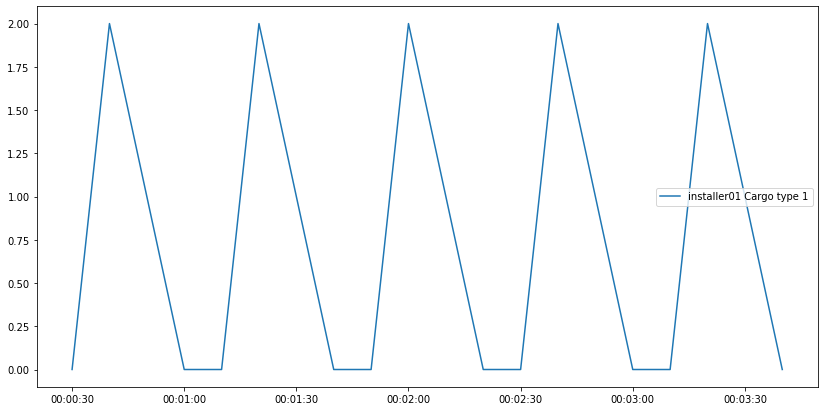

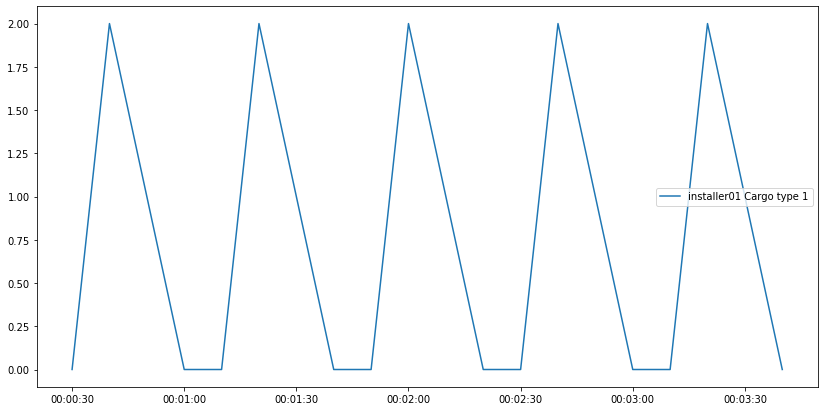

In [12]:
plot.get_step_chart([installer01])

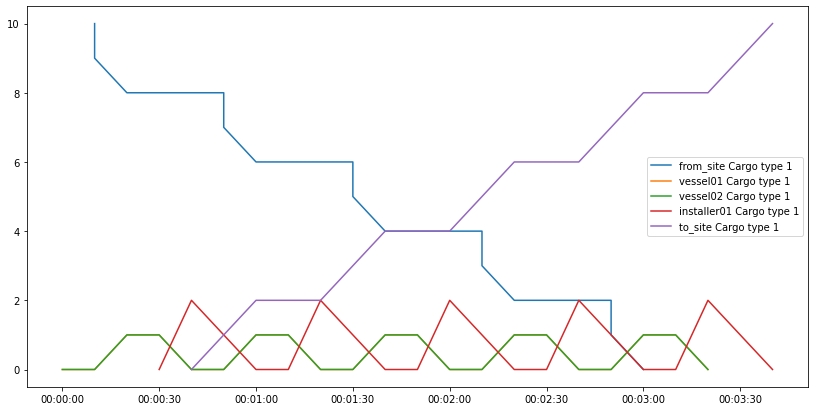

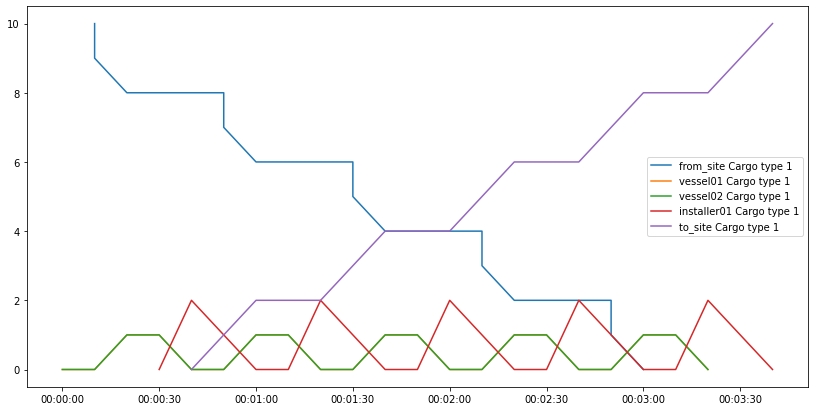

In [13]:
plot.get_step_chart([from_site, vessel01, vessel02, installer01, to_site])